# Pedestrian Forecasting
***

## Preparation

We start by installing the packages we need.

Import packages.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Data preparation
This dataset contains hourly pedestrian counts since 2009 from pedestrian sensor devices located across the city of Melbourne, Australia. The data is updated on a monthly basis and can be used to determine variations in pedestrian activity throughout the day. https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp

In [ ]:
# Read
df = pd.read_csv('data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv', usecols=['Date_Time', 'Sensor_Name', 'Hourly_Counts'])

df.head()

In [ ]:
# Convert date to datetime
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# Group all sensors
df_grouped = df.groupby(['Date_Time']).agg({'Hourly_Counts': 'sum'}).rename(columns={'Hourly_Counts': 'Count_Pedestrians'})

# Aggregate weekly
df_weekly = df_grouped.resample('W').sum()

# Filter from the start of 2010 to end of 2019
df_weekly = df_weekly['2010-01-01': '2019-12-31']

In [ ]:
df_weekly

In [ ]:
y = df_weekly.squeeze() # prepare the data as a pandas Series

In [ ]:
df

## Exploratory Data Analysis

We now plot our weekly data.

In [ ]:
df_weekly.plot(figsize=(12,6), title='Count of pedestrians in Melbourne', xlabel='Date', ylabel='Count pedestrians')
plt.show()

We now aggregate our weekly data to monthly and plot.

In [ ]:
df_weekly.resample('M').sum().plot(figsize=(12,6), title='Count of pedestrians in Melbourne', xlabel='Date', ylabel='Count pedestrians')
plt.show()

We also check if our data is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_weekly.values.flatten())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
df = df.iloc[-50:]
# df = df.iloc[-120:]
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)


prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=2)
# df["EMA"] = talib.EMA(prices, timeperiod=200)
# df['TEMA'] = talib.TRIMA(prices, timeperiod=200*2)

# df['ATR'] = talib.NATR(df['High'], df['Low'], df['Close'], timeperiod=200)
# df["EMA"] = ema
df = df.dropna()
df = df[['SMA']]
df

,SMA
100126,1.096765
100127,1.096425
100128,1.096665
100129,1.096900
100130,1.096825
100131,1.096795
100132,1.096890
100133,1.096770
100134,1.096520
100135,1.096460


In [ ]:
import datetime as dt
# freq = pd.offsets.BusinessHour(start="00:00", end="23:00")
freq = pd.offsets.Hour()
freq

In [ ]:
df = df.asfreq(freq)

df

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

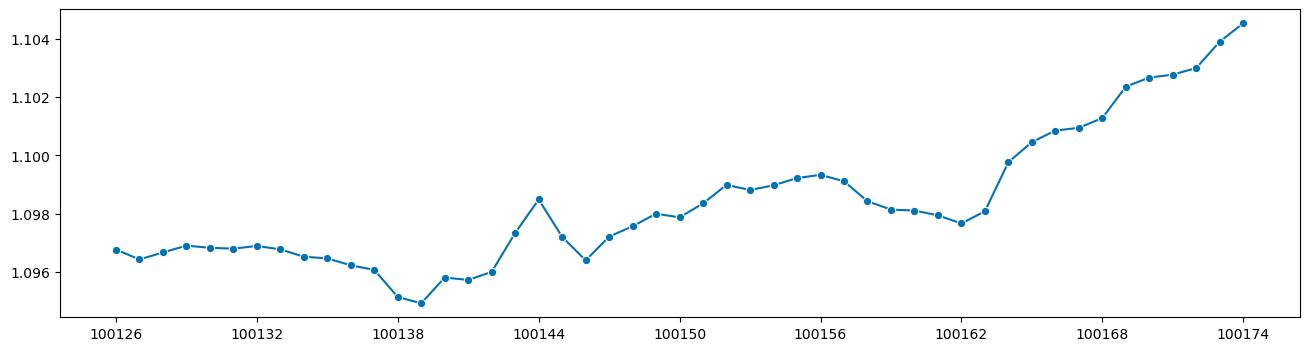

In [5]:
from sktime.utils.plotting import plot_series
plot_series(df)

## Forecasting

### Multiple Linear Regression

In [ ]:
# df = df.interpolate().asfreq('CBH')
# df = df.interpolate().asfreq(freq)

In [ ]:
df

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split
y = df
y_train, y_test = temporal_train_test_split(y, test_size=10) # Predict from 1st July 2019

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

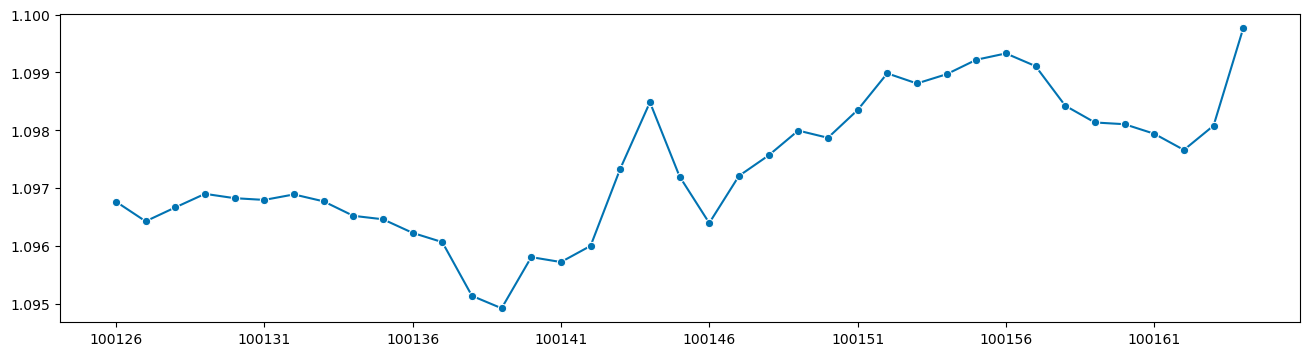

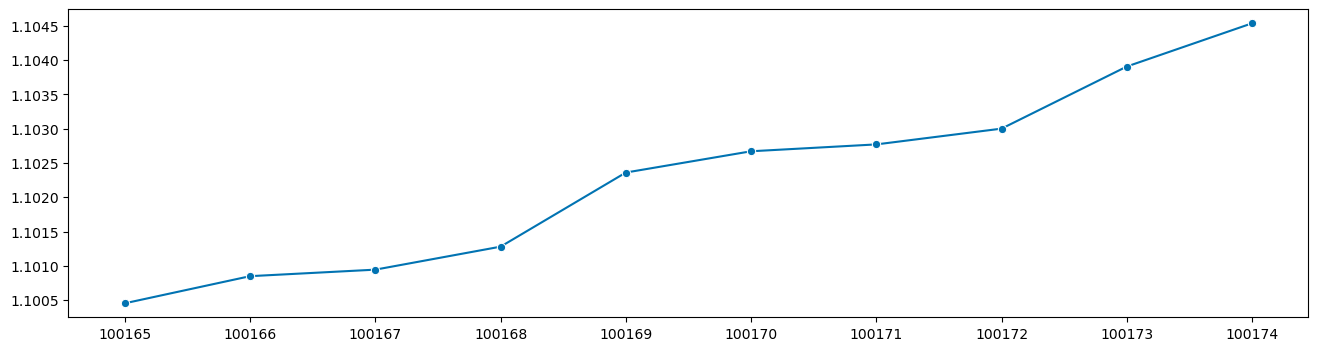

In [6]:
plot_series(y_train)
plot_series(y_test)


In [ ]:
# remove fi
y_train.index

In [ ]:
y_test.index

In [ ]:
y_train.index

In [8]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
forecaster.fit(y_train)



RecursiveTabularRegressionForecaster(estimator=LinearRegression(),
                                     window_length=5)

In [9]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='Count pedestrians'>)

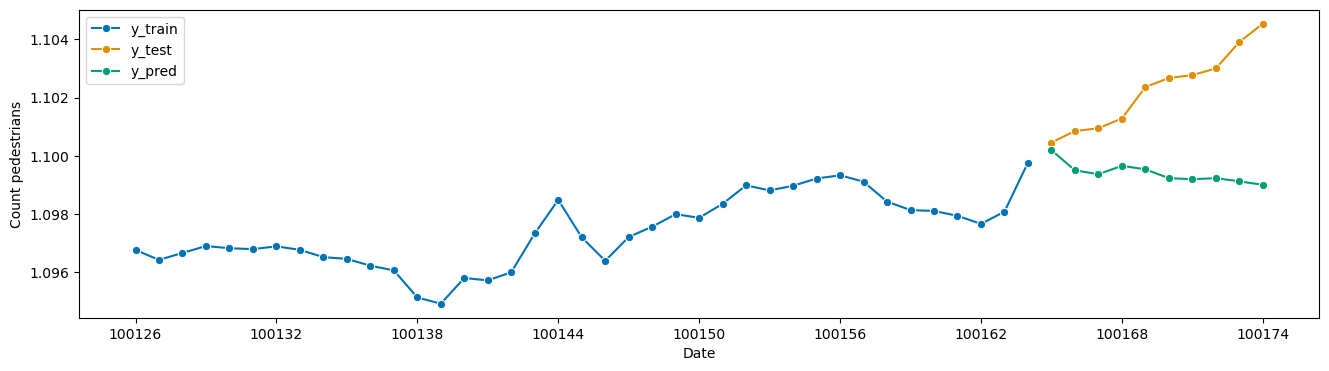

In [10]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians')

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.trend import TrendForecaster
y = load_airline()
forecaster = TrendForecaster()
forecaster.fit(  y)

y_pred = forecaster.predict(fh=[1,2,3])

In [ ]:
y_pred

### XGBoost with multiple inputs

In [ ]:
from xgboost import XGBRegressor

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")

In [ ]:
# Create an exogenous dataframe indicating the month
X = pd.DataFrame({'month': y.index.month}, index=y.index)
X = pd.get_dummies(X.astype(str), drop_first=True)

# Split into train and test
X_train, X_test = temporal_train_test_split(X, test_size=26) # Predict from 1st July 2019

In [ ]:
# Fit
forecaster.fit(y=y_train, X=X_train)

# Predict
y_pred = forecaster.predict(fh=fh, X=X_test)

In [ ]:
plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [ ]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

### Tuning the hyperparameters of our forecaster
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [ ]:
from sktime.forecasting.model_selection import SingleWindowSplitter

validation_size = 26
cv = SingleWindowSplitter(window_length=len(y)-validation_size, fh=validation_size)

In [ ]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")

gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

In [ ]:
# Fit
gscv.fit(y=y_train, X=X_train)

# Predict
y_pred = gscv.predict(fh=fh, X=X_test)

In [ ]:
gscv.cv_results_

In [ ]:
plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [ ]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

## Adding components to our forecasting pipeline

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (8,10)

result = seasonal_decompose(y_train, model='multiplicative')
result.plot()
plt.show()

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive"),
        ),
    ]
)

In [ ]:
param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

In [ ]:
# Fit
gscv.fit(y=y_train, X=X_train)

# Predict
y_pred = gscv.predict(fh=fh, X=X_test)

In [ ]:
gscv.cv_results_

In [ ]:
gscv.cv_results_.iloc[0, 3]

In [ ]:
plot_series(y_train['2018-07-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

In [ ]:
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))